In [131]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
import tqdm
sys.path.append('..')

In [132]:
import xgboost as xgb
import yaml
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import optuna
from functools import partial
import scipy.spatial.distance as ssd
from sklearn.decomposition import PCA

In [133]:
import src.dax_utils as utils

In [134]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [135]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

### Constants

In [136]:
FEATURE_SELECTION_AUC_DROP_THRESHOLD = .05

### Read in artifacts

In [137]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

In [138]:
X_train.shape

(3204, 1897)

### Baseline model

In [139]:
xgb_model = xgb.XGBClassifier(N_estimators=1200, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(N_estimators=1200, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [140]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

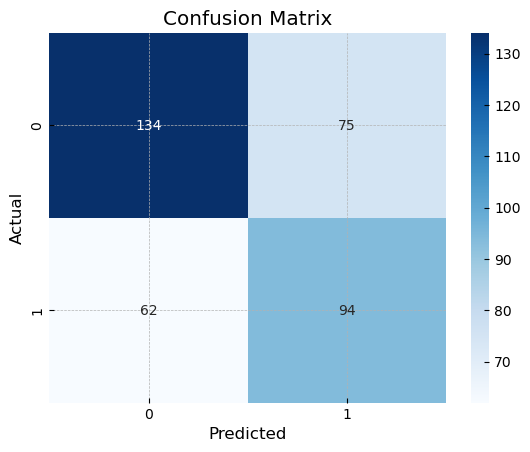

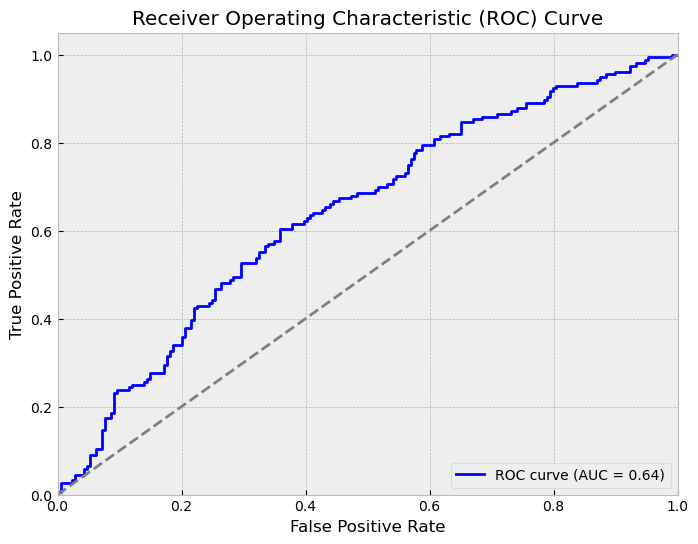

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       209
           1       0.56      0.60      0.58       156

    accuracy                           0.62       365
   macro avg       0.62      0.62      0.62       365
weighted avg       0.63      0.62      0.63       365



In [141]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Feature Selection

Lasso selection

In [142]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [143]:
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))

# train Lasso model and select features
sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [144]:
X_train = X_train[X_train.columns[sel_.get_support()]]
X_test = X_test[X_test.columns[sel_.get_support()]]

In [145]:
X_train.shape

(3204, 1145)

In [146]:
xgb_model = xgb.XGBClassifier(N_estimators=1200, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(N_estimators=1200, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [147]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

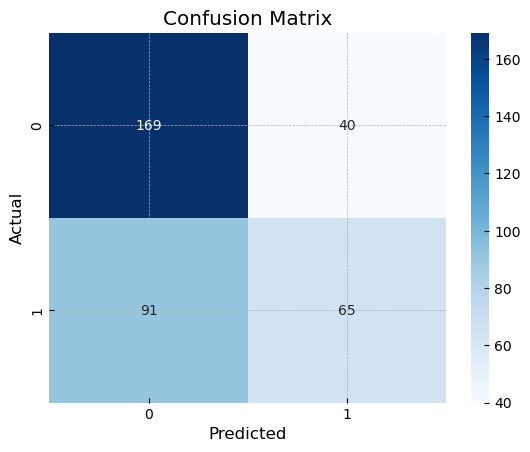

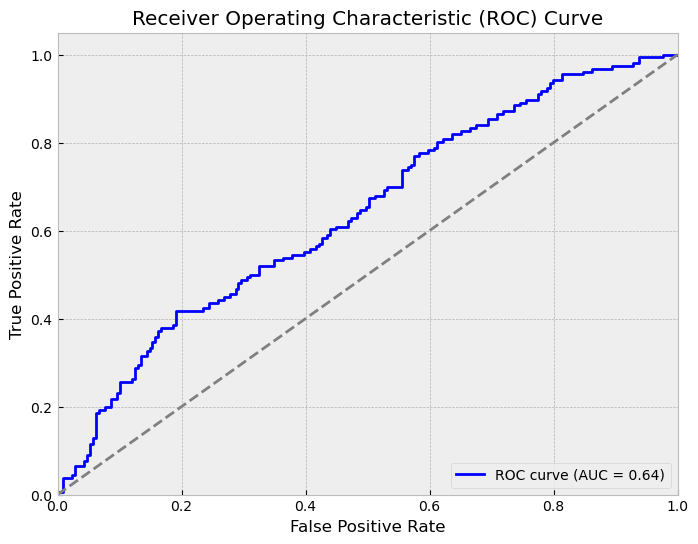

              precision    recall  f1-score   support

           0       0.65      0.81      0.72       209
           1       0.62      0.42      0.50       156

    accuracy                           0.64       365
   macro avg       0.63      0.61      0.61       365
weighted avg       0.64      0.64      0.63       365



In [148]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

Logreg

In [149]:
X_sm_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm_train)
results = model.fit()

         Current function value: 0.310884
         Iterations: 35


In [150]:
number_of_significant_features = (results.pvalues < .05).sum() # 42

In [151]:
number_of_significant_features

313

In [152]:
results.pvalues[results.pvalues < .05].sort_values().head(15)

const                                         0.00
low_bnd_low_vol5d close_ief_spy_corr10d       0.00
high_gld_day20 volume_ief_day20               0.00
close_ief_spy_corr10d close_spy_ief_corr10d   0.00
close_bnd volume_ief_day3                     0.00
low_gld_day20 volume_ief_day20                0.00
market_closed low_ief_low_vol5d               0.00
sunrise_dusk                                  0.00
business_days_in_month low_gld_low_vol3d      0.00
market_closed                                 0.00
month_first_day close_ief_spy_corr10d         0.00
close_bnd savgol_close_bnd_w10_p3             0.00
volume_ief_day1 open_gdaxi_day20              0.00
close_gld high_gdaxi_day3                     0.00
volume_ief_day7 bnd_rsi                       0.00
dtype: float64

In [156]:
X_train = X_train[[c for c in X_train.columns if c in results.pvalues[results.pvalues < .05]]]
X_test = X_test[[c for c in X_train.columns if c in results.pvalues[results.pvalues < .05]]]

In [157]:
X_train.shape

(3204, 312)

In [158]:
tree_based_feature_importances = utils.Tools.get_tree_model_feature_importances(xgb_model, X_train.columns)

In [159]:
tree_based_feature_importances.tail(15)

low_gld close_spy_gld_corr10d            0.00
volume_ief_day7 bnd_rsi                  0.00
volume_ief_day7 month_first_day          0.00
volume_ief_day7 volume_ief_day20         0.00
volume_bnd_day7 close_gdaxi_day20        0.00
open_ief_day3 close_spy_day20            0.00
high_bnd volume_ief_day3                 0.00
high_gdaxi_day7 close_gdaxi_day20        0.00
high_bnd low_gld_day7                    0.00
low_gld_day7 close_ief_spy_corr10d       0.00
market_closed close_gdaxi_vol5d          0.00
low_bnd_day7 low_gld_day7                0.00
close_gdaxi_day3 close_spy_gld_corr10d   0.00
volume_ief_day3 high_gld_high_vol5d      0.00
low_spy_day3 close_spy_gld_corr10d       0.00
dtype: float32

In [160]:
X_train = X_train[[c for c in X_train.columns if c not in tree_based_feature_importances[tree_based_feature_importances == 0].index]]
X_test = X_test[[c for c in X_train.columns if c not in tree_based_feature_importances[tree_based_feature_importances == 0].index]]

In [161]:
X_train.shape

(3204, 260)

Forward Selection

In [162]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, f1_score, make_scorer

In [96]:
# from sklearn.metrics import precision_score, roc_auc_score

# def combined_score(y_true, y_pred, precision_weight=0.2):
#     """
#     Computes a combined score using precision and AUC scores.

#     Parameters:
#     - y_true: array-like of shape (n_samples,) - True binary labels.
#     - y_pred: array-like of shape (n_samples,) - Predicted binary labels.
#     - precision_weight: float, default=0.5 - Weight of the precision score in the combined score.

#     Returns:
#     - combined_score: float - The combined score.
#     """
#     precision = precision_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred)
    
#     combined_score = precision_weight * precision + (1 - precision_weight) * f1
#     return combined_score

In [163]:
# # Build EXC classifier to use in feature selection
# # clf = ExtraTreesClassifier(n_estimators=60, n_jobs=-1, random_state=42)
# clf = xgb.XGBClassifier(random_state=42)
# timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=4)
# combined_scorer = make_scorer(combined_score, greater_is_better=True)

# # Build step forward feature selection
# sfs1 = sfs(clf, 
#            n_jobs=-1,
#            k_features=30,
#            forward=True,
#            floating=False,
#            verbose=2,
#            scoring=combined_score, # 'f1'
#            cv=timeseries_splitter) # 4

# # Perform SFFS
# sfs1 = sfs1.fit(X_train, y_train) 

In [164]:
import numpy as np
from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import precision_score, f1_score, make_scorer
from xgboost import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [165]:
def combined_score(y_true, y_pred, precision_weight=0.1):
    """
    Computes a combined score using precision and F1 scores.

    Parameters:
    - y_true: array-like of shape (n_samples,) - True binary labels.
    - y_pred: array-like of shape (n_samples,) - Predicted binary labels.
    - precision_weight: float, default=0.5 - Weight of the precision score in the combined score.

    Returns:
    - combined_score: float - The combined score.
    """
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    combined_score = precision_weight * precision + (1 - precision_weight) * f1
    return combined_score

In [167]:
class ReasonableTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        split_size = n_samples // (self.n_splits + 1)
        indices = np.arange(n_samples)

        for i in range(self.n_splits):
            train_start = i * split_size
            train_end = (i + 1) * split_size
            test_start = train_end
            test_end = test_start + split_size
            
            if test_end > n_samples:
                test_end = n_samples

            train_indices = indices[train_start:train_end]
            test_indices = indices[test_start:test_end]

            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits



# Create a scorer using make_scorer
combined_scorer = make_scorer(combined_score, greater_is_better=True)

clf = XGBClassifier(N_estimators=1200, random_state=42)
timeseries_splitter = ReasonableTimeSeriesSplit(n_splits=4)

# Build step forward feature selection
sfs1 = SFS(clf, 
           k_features=30,
           forward=True,
           floating=False,
           verbose=2,
           scoring=combined_scorer,  # Use the custom scorer
           cv=timeseries_splitter,
           n_jobs=-1)

# Example usage
# X, y should be your dataset


In [168]:
sfs1.fit(X_train, y_train)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    8.0s finished

[2024-07-21 16:55:56] Features: 1/30 -- score: 0.4627324274349534[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 259 out of 259 | elapsed:    6.0s finished

[2024-07-21 16:56:02] Features: 2/30 -- score: 0.4806074986375833[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 258 out of 258 | elapsed:    7.5s finished

[2024-07-21 16:56:10] Features: 3/30 -- score: 0.49

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 236 out of 236 | elapsed:   32.2s finished

[2024-07-21 17:03:18] Features: 25/30 -- score: 0.5022955355346773[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:   31.9s finished

[2024-07-21 17:03:50] Features: 26/30 -- score: 0.5016801460336804[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:   32.4s finished

[2024-07-21 17:04:22] Features: 27/30 -- score: 0.5015142435846247[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 con

[0, 4, 18, 28, 44, 45, 54, 55, 59, 66, 73, 76, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 122, 147, 173, 205, 225, 226, 244, 249]


[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:   33.3s finished

[2024-07-21 17:06:00] Features: 30/30 -- score: 0.4984860819037717

In [102]:
# feat_cols =  [27, 58, 61, 64, 74, 80, 82, 97, 121, 122, 139, 189, 198, 206, 209, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 246, 286, 287, 328, 364, 376, 425, 441, 456, 459, 467, 495, 503, 510, 518, 562, 565, 604, 636, 645, 646]

In [169]:
X_train.columns[feat_cols]

Index(['market_closed', 'close_gdaxi_day1', 'anomaly',
       'low_gld open_spy_day20', 'high_gld low_gld_day7',
       'high_gld high_bnd_day7', 'high_spy month_first_day',
       'high_spy business_days_in_month', 'volume_ief volume_gld_day3',
       'close_bnd low_gdaxi_day1', 'close_gld market_closed',
       'close_gld volume_gld_day1', 'market_closed open_gdaxi_day1',
       'market_closed high_gdaxi_day3', 'market_closed volume_bnd_day3',
       'market_closed low_bnd_day7', 'market_closed close_spy_day7',
       'market_closed gld_rsi', 'market_closed low_ief_low_vol5d',
       'market_closed close_ief_spy_corr10d',
       'low_spy_day1 high_spy_high_vol3d', 'low_spy_day1 low_bnd_low_vol5d',
       'volume_ief_day1 close_spy_day20', 'volume_bnd_day3 volume_ief_day20',
       'low_gld_day7 high_gld_day20', 'low_gld_day20 month_first_day',
       'close_gld_day20 gdaxi_rsi', 'close_gld_day20 high_spy_high_vol3d',
       'open_gdaxi_kmomentum low_spy_low_vol3d', 'ief_rsi low_spy_l

In [170]:
X_train = X_train[X_train.columns[feat_cols]]
X_test = X_test[X_test.columns[feat_cols]]

In [171]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [172]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

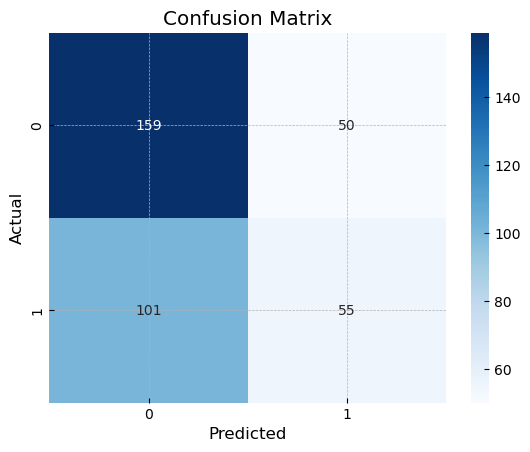

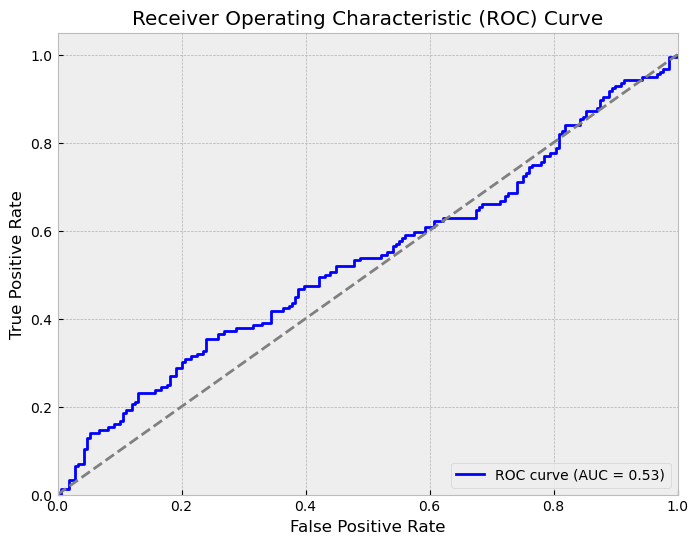

              precision    recall  f1-score   support

           0       0.61      0.76      0.68       209
           1       0.52      0.35      0.42       156

    accuracy                           0.59       365
   macro avg       0.57      0.56      0.55       365
weighted avg       0.57      0.59      0.57       365



In [173]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [174]:
import shap

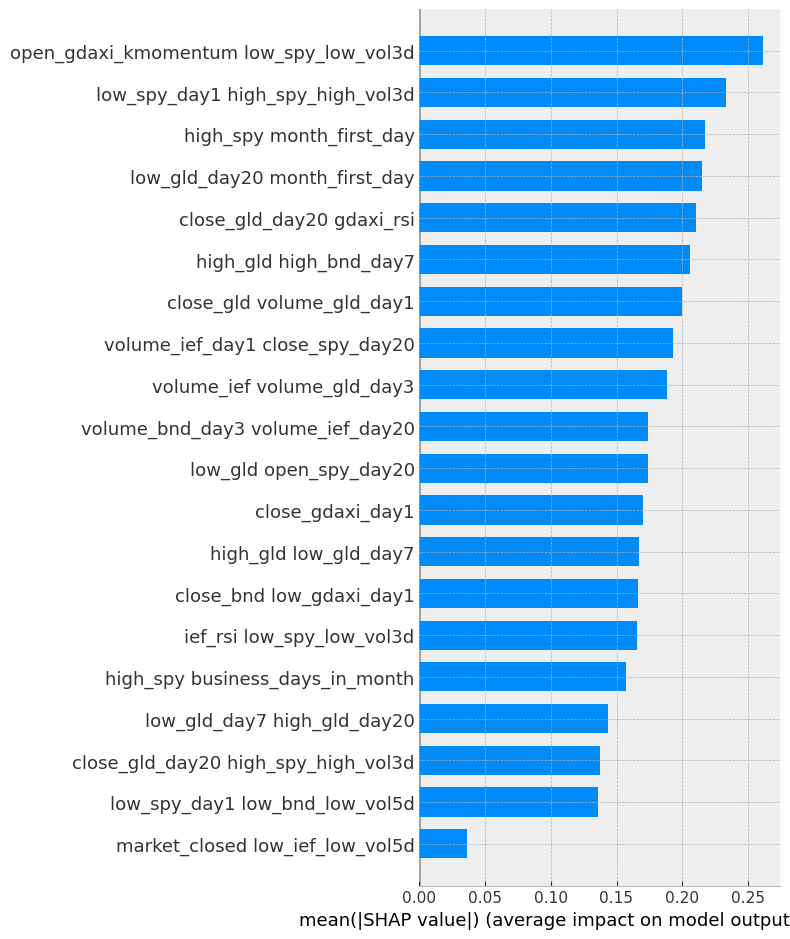

In [175]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Recurise Feature Elimination with Custom TimeSeriesSplit

In [176]:
# baseline_score = roc_auc_score(y_test, y_prob[:,1])
# baseline_score

In [177]:
scores = list()
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=3)

for train_index, test_index in timeseries_splitter.split(X_train):
    # print("TRAIN:", len(train_index), "TEST:", len(test_index))
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
    
    scores.append(
        roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])
    )

In [178]:
baseline_score = np.array(scores).mean()
baseline_score

0.5521515922285153

In [179]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

In [184]:
del RFE_FEATURES; del _RFE_FEATURES

In [185]:
X_train.columns.shape[0]

30

In [186]:
big_step, small_step = 3, 1
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=6)
number_of_features = X_train.columns.shape[0] - big_step
step = big_step
current_score = baseline_score
all_scores = {}

progress_bar = tqdm.tqdm(total=number_of_features, desc="Processing")

n = 0
while current_score > (baseline_score - FEATURE_SELECTION_AUC_DROP_THRESHOLD) and number_of_features > 0:
    try:
        RFE_FEATURES = _RFE_FEATURES.copy()
    except NameError:
        RFE_FEATURES = X_train.columns
    
    rfe = RFE(estimator=xgb_model, n_features_to_select=number_of_features)
    rfe.fit(X_train[RFE_FEATURES], y_train)
    
    _RFE_FEATURES = X_train[RFE_FEATURES].columns[rfe.support_]
    
    scores = list()
    for train_index, test_index in timeseries_splitter.split(X_train):
        # print("TRAIN:", len(train_index), "TEST:", len(test_index))
        xgb_model = xgb.XGBClassifier(random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:].loc[:,_RFE_FEATURES], y_train.iloc[train_index])

        scores.append(
            roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:].loc[:,_RFE_FEATURES])[:,1])
        )

    current_score = np.array(scores).mean()
    all_scores[number_of_features] = scores.copy()
    
    if n % 5 == 0:
        FEATURE_SELECTION_AUC_DROP_THRESHOLD = FEATURE_SELECTION_AUC_DROP_THRESHOLD - .01
        step = step - 1
        
    number_of_features = number_of_features - step
    progress_bar.set_description(f"Processing (AUC: {current_score:.4f})")
    progress_bar.update(step)
    n += 1

progress_bar.close()


Processing:   0%|                                                                               | 0/27 [00:09<?, ?it/s]

Processing (AUC: 0.5622):   0%|                                                         | 0/27 [00:14<00:14,  1.87it/s]
Processing (AUC: 0.5622): -11%|                                                        | -3/27 [00:14<00:16,  1.87it/s]
Processing (AUC: 0.5622): -22%|                                                        | -6/27 [00:15<00:17,  1.87it/s]
Processing (AUC: 0.5622): -33%|                                                        | -9/27 [00:15<00:19,  1.87it/s]
Processing (AUC: 0.5622): -44%|                                                       | -12/27 [00:15<00:20,  1.87it/s]
Processing (AUC: 0.5622): -70%|                                                    | -19/27 [00:16<-1:59:21, -1.16it/s]


In [187]:
RFE_FEATURES

Index(['low_gld open_spy_day20', 'high_gld high_bnd_day7',
       'volume_ief volume_gld_day3', 'close_gld volume_gld_day1',
       'low_spy_day1 high_spy_high_vol3d', 'low_spy_day1 low_bnd_low_vol5d',
       'volume_ief_day1 close_spy_day20', 'volume_bnd_day3 volume_ief_day20',
       'low_gld_day7 high_gld_day20', 'low_gld_day20 month_first_day',
       'close_gld_day20 gdaxi_rsi', 'open_gdaxi_kmomentum low_spy_low_vol3d'],
      dtype='object')

### Test Reduced Feature Set

In [188]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [189]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

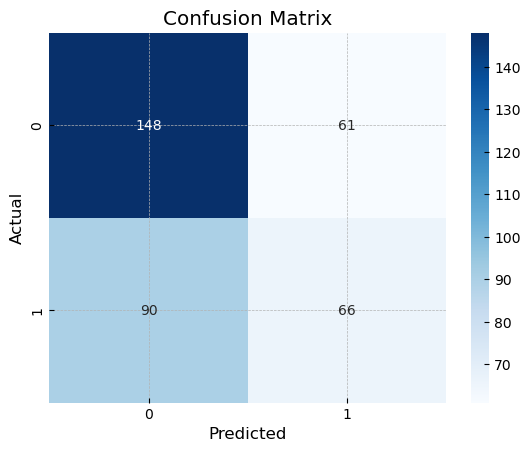

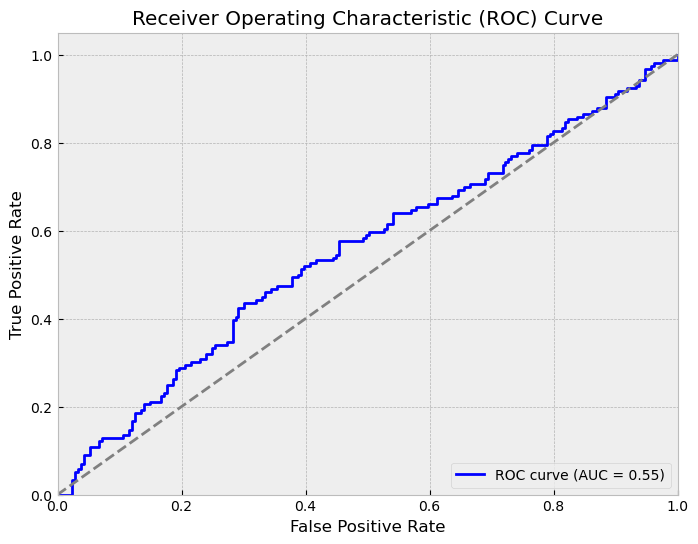

              precision    recall  f1-score   support

           0       0.62      0.71      0.66       209
           1       0.52      0.42      0.47       156

    accuracy                           0.59       365
   macro avg       0.57      0.57      0.56       365
weighted avg       0.58      0.59      0.58       365



In [190]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [121]:
# shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

### Hyperparam optimization

In [191]:
def objective_xgboost_classification(X_train, y_train, trial):

    # _X_train, X_valid = X_train[:int(X_train.shape[0] * .7)], X_train[int(X_train.shape[0] * .7):]
    # _y_train, y_valid = y_train[:int(X_train.shape[0] * .7)], y_train[int(X_train.shape[0] * .7):]

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 900, 2000),
        'max_depth': trial.suggest_int('max_depth', 8, 18),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1),
        'min_child_weight': trial.suggest_int('min_child_weight', 6, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e-1),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'verbose' : -1
    }
    
    steps = 5
    timeseries_splitter = ReasonableTimeSeriesSplit(n_splits=steps)
    scores = np.empty(steps)
    
    for idx, (train_index, test_index) in enumerate(timeseries_splitter.split(X_train)):
        xgb_model = xgb.XGBClassifier(**params, random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
        scores[idx] = roc_auc_score(y_train.iloc[test_index], 
                                    xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])

    
    # Initialize the XGBoost classifier model with hyperparameters
    # model = xgb.XGBClassifier(**params, random_state=42)
    
    # Train the model
    # model.fit(_X_train, _y_train)
    
    # Evaluate the model on the validation set using AUC
    # y_pred_proba = model.predict_proba(X_valid)[:, 1]
    # score = roc_auc_score(y_valid, y_pred_proba)
    # score = recall_score(y_valid, y_pred_proba)
    
    return scores.mean()

In [200]:
# Define the study and optimize hyperparameters
study_xgboost_classification = optuna.create_study(direction='maximize')
objective = partial(objective_xgboost_classification, X_train.loc[:,RFE_FEATURES], y_train)
study_xgboost_classification.optimize(objective, n_trials=400)

[I 2024-07-21 17:34:49,308] A new study created in memory with name: no-name-fa0ae85f-fc25-4b47-9c2d-e67bd9112071
[I 2024-07-21 17:34:51,523] Trial 0 finished with value: 0.549128646327022 and parameters: {'n_estimators': 1505, 'max_depth': 8, 'learning_rate': 0.04344426149960239, 'subsample': 0.8317275580480377, 'colsample_bytree': 0.957028889581278, 'gamma': 0.017805393317051003, 'min_child_weight': 9, 'reg_alpha': 0.08347142083335375, 'reg_lambda': 0.06644194629922005}. Best is trial 0 with value: 0.549128646327022.
[I 2024-07-21 17:34:53,347] Trial 1 finished with value: 0.5460530268605824 and parameters: {'n_estimators': 1202, 'max_depth': 12, 'learning_rate': 0.06399274898372173, 'subsample': 0.9456242544429745, 'colsample_bytree': 0.8271082351049293, 'gamma': 0.02171073197949559, 'min_child_weight': 8, 'reg_alpha': 0.07074869924629064, 'reg_lambda': 0.04982061767192933}. Best is trial 0 with value: 0.549128646327022.
[I 2024-07-21 17:34:55,787] Trial 2 finished with value: 0.554

[I 2024-07-21 17:35:33,245] Trial 20 finished with value: 0.5509852921648628 and parameters: {'n_estimators': 961, 'max_depth': 17, 'learning_rate': 0.07771999782775477, 'subsample': 0.6057211169810287, 'colsample_bytree': 0.8777632614784545, 'gamma': 0.09948724263554178, 'min_child_weight': 6, 'reg_alpha': 0.0015386978041760974, 'reg_lambda': 0.04032399025447515}. Best is trial 12 with value: 0.5665836978096085.
[I 2024-07-21 17:35:34,996] Trial 21 finished with value: 0.5639765167709172 and parameters: {'n_estimators': 909, 'max_depth': 18, 'learning_rate': 0.0014207188265276869, 'subsample': 0.5585572472127522, 'colsample_bytree': 0.862914615677671, 'gamma': 0.053824910388805006, 'min_child_weight': 6, 'reg_alpha': 0.012715467612897314, 'reg_lambda': 0.010032627415613225}. Best is trial 12 with value: 0.5665836978096085.
[I 2024-07-21 17:35:37,056] Trial 22 finished with value: 0.5564505122659362 and parameters: {'n_estimators': 1008, 'max_depth': 17, 'learning_rate': 0.009629864916

[I 2024-07-21 17:36:10,808] Trial 40 finished with value: 0.5544091028169743 and parameters: {'n_estimators': 905, 'max_depth': 10, 'learning_rate': 0.0529143228273363, 'subsample': 0.6296862364331021, 'colsample_bytree': 0.9034907319621025, 'gamma': 0.07261280859012884, 'min_child_weight': 7, 'reg_alpha': 0.09116948423040602, 'reg_lambda': 0.03186229623370749}. Best is trial 12 with value: 0.5665836978096085.
[I 2024-07-21 17:36:12,577] Trial 41 finished with value: 0.5651066502871538 and parameters: {'n_estimators': 940, 'max_depth': 18, 'learning_rate': 0.0003091799561944111, 'subsample': 0.5335108872882871, 'colsample_bytree': 0.8678963080889713, 'gamma': 0.06358780042672248, 'min_child_weight': 6, 'reg_alpha': 0.007255208613486264, 'reg_lambda': 0.015015899245812675}. Best is trial 12 with value: 0.5665836978096085.
[I 2024-07-21 17:36:14,463] Trial 42 finished with value: 0.5654823490221246 and parameters: {'n_estimators': 1002, 'max_depth': 17, 'learning_rate': 0.000451872148153

[I 2024-07-21 17:36:51,980] Trial 60 finished with value: 0.5610812879959803 and parameters: {'n_estimators': 1025, 'max_depth': 18, 'learning_rate': 0.0036675248978237825, 'subsample': 0.8219654821801736, 'colsample_bytree': 0.9796636538203529, 'gamma': 0.05213962660479832, 'min_child_weight': 6, 'reg_alpha': 0.022063380764982904, 'reg_lambda': 0.015780814882914024}. Best is trial 12 with value: 0.5665836978096085.
[I 2024-07-21 17:36:53,720] Trial 61 finished with value: 0.5647202862978588 and parameters: {'n_estimators': 904, 'max_depth': 18, 'learning_rate': 0.00016214474985731234, 'subsample': 0.5494822634615822, 'colsample_bytree': 0.8735244546290426, 'gamma': 0.06697694525626192, 'min_child_weight': 6, 'reg_alpha': 0.01097350679523118, 'reg_lambda': 0.01786362854908539}. Best is trial 12 with value: 0.5665836978096085.
[I 2024-07-21 17:36:55,475] Trial 62 finished with value: 0.5562472632335195 and parameters: {'n_estimators': 988, 'max_depth': 18, 'learning_rate': 0.00840006464

[I 2024-07-21 17:37:28,633] Trial 80 finished with value: 0.555696663019343 and parameters: {'n_estimators': 1208, 'max_depth': 11, 'learning_rate': 0.013155115031402383, 'subsample': 0.5667231136424826, 'colsample_bytree': 0.8750412150994735, 'gamma': 0.057487786281969586, 'min_child_weight': 7, 'reg_alpha': 0.01158973572660545, 'reg_lambda': 0.016017998537649084}. Best is trial 71 with value: 0.5665881115302274.
[I 2024-07-21 17:37:30,536] Trial 81 finished with value: 0.5649896552605446 and parameters: {'n_estimators': 1113, 'max_depth': 18, 'learning_rate': 0.001764970968475666, 'subsample': 0.5073985416594985, 'colsample_bytree': 0.9018941004491198, 'gamma': 0.027380486373070605, 'min_child_weight': 7, 'reg_alpha': 0.006433598750447049, 'reg_lambda': 0.011214124107137964}. Best is trial 71 with value: 0.5665881115302274.
[I 2024-07-21 17:37:32,262] Trial 82 finished with value: 0.5609792395117745 and parameters: {'n_estimators': 1081, 'max_depth': 18, 'learning_rate': 0.0055393307

[I 2024-07-21 17:38:06,236] Trial 100 finished with value: 0.557449266520004 and parameters: {'n_estimators': 952, 'max_depth': 17, 'learning_rate': 0.011998465419817425, 'subsample': 0.5783172143644749, 'colsample_bytree': 0.8868037034053591, 'gamma': 0.0439411441797041, 'min_child_weight': 6, 'reg_alpha': 0.033871497458559274, 'reg_lambda': 0.027554442844015092}. Best is trial 97 with value: 0.5665947164912976.
[I 2024-07-21 17:38:08,042] Trial 101 finished with value: 0.5659387318196134 and parameters: {'n_estimators': 949, 'max_depth': 18, 'learning_rate': 0.00046129215917276267, 'subsample': 0.5448573806085467, 'colsample_bytree': 0.8712196238137766, 'gamma': 0.05089119870268921, 'min_child_weight': 6, 'reg_alpha': 0.012576418818609766, 'reg_lambda': 0.01920146405592217}. Best is trial 97 with value: 0.5665947164912976.
[I 2024-07-21 17:38:09,947] Trial 102 finished with value: 0.5612146833015308 and parameters: {'n_estimators': 1050, 'max_depth': 18, 'learning_rate': 0.0044562383

[I 2024-07-21 17:38:44,628] Trial 120 finished with value: 0.5571403880393224 and parameters: {'n_estimators': 956, 'max_depth': 18, 'learning_rate': 0.014073328371654143, 'subsample': 0.5009239417715301, 'colsample_bytree': 0.9377840259345005, 'gamma': 0.04767973042348133, 'min_child_weight': 6, 'reg_alpha': 0.010659922614322614, 'reg_lambda': 0.019232003220951675}. Best is trial 105 with value: 0.5669253963897388.
[I 2024-07-21 17:38:46,346] Trial 121 finished with value: 0.565471447527354 and parameters: {'n_estimators': 901, 'max_depth': 18, 'learning_rate': 0.0002126922516071429, 'subsample': 0.5339357728423977, 'colsample_bytree': 0.9653718665807262, 'gamma': 0.04104896344876994, 'min_child_weight': 6, 'reg_alpha': 0.005088832474865231, 'reg_lambda': 0.034374213000818526}. Best is trial 105 with value: 0.5669253963897388.
[I 2024-07-21 17:38:48,311] Trial 122 finished with value: 0.5646826779884802 and parameters: {'n_estimators': 1014, 'max_depth': 17, 'learning_rate': 0.0018380

[I 2024-07-21 17:39:22,409] Trial 140 finished with value: 0.5648353434461715 and parameters: {'n_estimators': 919, 'max_depth': 18, 'learning_rate': 0.0001536725228358563, 'subsample': 0.5512239585216309, 'colsample_bytree': 0.8571631806400692, 'gamma': 0.03752633554481497, 'min_child_weight': 8, 'reg_alpha': 0.005057823492077399, 'reg_lambda': 0.017501507321378413}. Best is trial 105 with value: 0.5669253963897388.
[I 2024-07-21 17:39:24,336] Trial 141 finished with value: 0.5659642491771631 and parameters: {'n_estimators': 1018, 'max_depth': 13, 'learning_rate': 0.00010352164404159227, 'subsample': 0.5401565862951658, 'colsample_bytree': 0.8779980735693307, 'gamma': 0.05257801616986037, 'min_child_weight': 6, 'reg_alpha': 0.002805264581769155, 'reg_lambda': 0.02085207861857889}. Best is trial 105 with value: 0.5669253963897388.
[I 2024-07-21 17:39:26,313] Trial 142 finished with value: 0.5635507566045224 and parameters: {'n_estimators': 1020, 'max_depth': 13, 'learning_rate': 0.0023

[I 2024-07-21 17:40:02,090] Trial 160 finished with value: 0.5615454927205505 and parameters: {'n_estimators': 1076, 'max_depth': 10, 'learning_rate': 0.004285980512987588, 'subsample': 0.5140653151411201, 'colsample_bytree': 0.9689504007580331, 'gamma': 0.036290405154704206, 'min_child_weight': 6, 'reg_alpha': 0.01865374717791468, 'reg_lambda': 0.01069770616513198}. Best is trial 105 with value: 0.5669253963897388.
[I 2024-07-21 17:40:04,194] Trial 161 finished with value: 0.5658530769618155 and parameters: {'n_estimators': 1123, 'max_depth': 18, 'learning_rate': 0.0002490327404131927, 'subsample': 0.524445391615982, 'colsample_bytree': 0.9715862025694202, 'gamma': 0.04811488391709011, 'min_child_weight': 6, 'reg_alpha': 0.00806301792600333, 'reg_lambda': 0.018308864594563802}. Best is trial 105 with value: 0.5669253963897388.
[I 2024-07-21 17:40:06,063] Trial 162 finished with value: 0.565335279506739 and parameters: {'n_estimators': 971, 'max_depth': 10, 'learning_rate': 0.002035402

[I 2024-07-21 17:40:37,082] Trial 180 finished with value: 0.5660004945602379 and parameters: {'n_estimators': 964, 'max_depth': 17, 'learning_rate': 0.00016774490489895167, 'subsample': 0.5182081226749987, 'colsample_bytree': 0.8711585794775948, 'gamma': 0.04066849698919573, 'min_child_weight': 7, 'reg_alpha': 0.043660728273521604, 'reg_lambda': 0.036280255753405696}. Best is trial 170 with value: 0.5672267897908617.
[I 2024-07-21 17:40:38,900] Trial 181 finished with value: 0.5659186654227855 and parameters: {'n_estimators': 995, 'max_depth': 18, 'learning_rate': 0.00012134459970017748, 'subsample': 0.5089483321617029, 'colsample_bytree': 0.896994002442195, 'gamma': 0.054430389805620004, 'min_child_weight': 6, 'reg_alpha': 0.05473132347943862, 'reg_lambda': 0.05131832387562113}. Best is trial 170 with value: 0.5672267897908617.
[I 2024-07-21 17:40:40,875] Trial 182 finished with value: 0.5632617393313316 and parameters: {'n_estimators': 1033, 'max_depth': 18, 'learning_rate': 0.00217

[I 2024-07-21 17:41:15,495] Trial 200 finished with value: 0.5664335386882074 and parameters: {'n_estimators': 979, 'max_depth': 9, 'learning_rate': 0.00018795387449590362, 'subsample': 0.5104397663064812, 'colsample_bytree': 0.8790137591930486, 'gamma': 0.04150905696316877, 'min_child_weight': 6, 'reg_alpha': 0.03933187124774424, 'reg_lambda': 0.05278830356680331}. Best is trial 170 with value: 0.5672267897908617.
[I 2024-07-21 17:41:17,290] Trial 201 finished with value: 0.5664218202342839 and parameters: {'n_estimators': 978, 'max_depth': 9, 'learning_rate': 0.00022106460799070627, 'subsample': 0.5091031541406278, 'colsample_bytree': 0.8811063452624811, 'gamma': 0.0416737172317633, 'min_child_weight': 6, 'reg_alpha': 0.041856905067357446, 'reg_lambda': 0.050757289189699}. Best is trial 170 with value: 0.5672267897908617.
[I 2024-07-21 17:41:19,141] Trial 202 finished with value: 0.5633373310765182 and parameters: {'n_estimators': 990, 'max_depth': 9, 'learning_rate': 0.0019506333407

[I 2024-07-21 17:41:53,653] Trial 220 finished with value: 0.5643257269343438 and parameters: {'n_estimators': 974, 'max_depth': 12, 'learning_rate': 0.003615023192149342, 'subsample': 0.5005073113501888, 'colsample_bytree': 0.9752454180538369, 'gamma': 0.04388873173381604, 'min_child_weight': 6, 'reg_alpha': 0.042613638235870124, 'reg_lambda': 0.042974604971850225}. Best is trial 170 with value: 0.5672267897908617.
[I 2024-07-21 17:41:55,466] Trial 221 finished with value: 0.5663960073444738 and parameters: {'n_estimators': 983, 'max_depth': 12, 'learning_rate': 0.00011748373445820304, 'subsample': 0.5108754781218023, 'colsample_bytree': 0.8737758152906436, 'gamma': 0.03732929180428721, 'min_child_weight': 6, 'reg_alpha': 0.04731927833986618, 'reg_lambda': 0.050725358493845435}. Best is trial 170 with value: 0.5672267897908617.
[I 2024-07-21 17:41:57,294] Trial 222 finished with value: 0.5642705111346504 and parameters: {'n_estimators': 962, 'max_depth': 12, 'learning_rate': 0.0019580

[I 2024-07-21 17:42:32,391] Trial 240 finished with value: 0.5579719211619105 and parameters: {'n_estimators': 916, 'max_depth': 11, 'learning_rate': 0.005749083707848768, 'subsample': 0.5136005004945029, 'colsample_bytree': 0.8496731412919099, 'gamma': 0.031966630778166985, 'min_child_weight': 6, 'reg_alpha': 0.053062496863549385, 'reg_lambda': 0.05659365613737787}. Best is trial 170 with value: 0.5672267897908617.
[I 2024-07-21 17:42:34,138] Trial 241 finished with value: 0.5672737570490208 and parameters: {'n_estimators': 922, 'max_depth': 11, 'learning_rate': 0.0003612486283952878, 'subsample': 0.5269514213158771, 'colsample_bytree': 0.8433291966763315, 'gamma': 0.035016431072339226, 'min_child_weight': 6, 'reg_alpha': 0.04956121058386158, 'reg_lambda': 0.05174982909079286}. Best is trial 241 with value: 0.5672737570490208.
[I 2024-07-21 17:42:35,927] Trial 242 finished with value: 0.5663369604886388 and parameters: {'n_estimators': 936, 'max_depth': 11, 'learning_rate': 0.00017937

[I 2024-07-21 17:43:06,438] Trial 260 finished with value: 0.5466644770348201 and parameters: {'n_estimators': 976, 'max_depth': 12, 'learning_rate': 0.09973791187257686, 'subsample': 0.5169096596055619, 'colsample_bytree': 0.8512818915654646, 'gamma': 0.019241477437344973, 'min_child_weight': 6, 'reg_alpha': 0.04858587448874911, 'reg_lambda': 0.05475249260208578}. Best is trial 241 with value: 0.5672737570490208.
[I 2024-07-21 17:43:08,216] Trial 261 finished with value: 0.5643215017861607 and parameters: {'n_estimators': 940, 'max_depth': 10, 'learning_rate': 0.0020119482076306015, 'subsample': 0.5283215458143038, 'colsample_bytree': 0.842205026643428, 'gamma': 0.026960820423240765, 'min_child_weight': 6, 'reg_alpha': 0.04549621589981191, 'reg_lambda': 0.05199691104997822}. Best is trial 241 with value: 0.5672737570490208.
[I 2024-07-21 17:43:10,008] Trial 262 finished with value: 0.5675333450639972 and parameters: {'n_estimators': 986, 'max_depth': 11, 'learning_rate': 0.00016588382

[I 2024-07-21 17:43:42,520] Trial 280 finished with value: 0.5633462566595909 and parameters: {'n_estimators': 978, 'max_depth': 12, 'learning_rate': 0.002129908986001487, 'subsample': 0.5279407219409169, 'colsample_bytree': 0.8100903078316891, 'gamma': 0.04188840425214506, 'min_child_weight': 6, 'reg_alpha': 0.04500592125870371, 'reg_lambda': 0.0401559439366751}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:43:44,165] Trial 281 finished with value: 0.5661845930339706 and parameters: {'n_estimators': 1034, 'max_depth': 11, 'learning_rate': 0.0002584080836736919, 'subsample': 0.514987761067456, 'colsample_bytree': 0.8271732314278892, 'gamma': 0.03376510496898878, 'min_child_weight': 8, 'reg_alpha': 0.04663880440846062, 'reg_lambda': 0.046144392023676005}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:43:45,986] Trial 282 finished with value: 0.5668347655154501 and parameters: {'n_estimators': 996, 'max_depth': 11, 'learning_rate': 0.00011210303

[I 2024-07-21 17:44:20,502] Trial 300 finished with value: 0.5605229215642286 and parameters: {'n_estimators': 1074, 'max_depth': 8, 'learning_rate': 0.0017684047153085666, 'subsample': 0.9842996234448294, 'colsample_bytree': 0.8145341345086341, 'gamma': 0.0408265608446342, 'min_child_weight': 6, 'reg_alpha': 0.040118616003588264, 'reg_lambda': 0.045114696929084874}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:44:22,225] Trial 301 finished with value: 0.56585168680958 and parameters: {'n_estimators': 1058, 'max_depth': 9, 'learning_rate': 0.00012279588011491306, 'subsample': 0.5368696894954964, 'colsample_bytree': 0.8243900121735873, 'gamma': 0.04261031592224307, 'min_child_weight': 8, 'reg_alpha': 0.042181751298061176, 'reg_lambda': 0.04151412982476821}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:44:24,079] Trial 302 finished with value: 0.5625046830834884 and parameters: {'n_estimators': 1020, 'max_depth': 11, 'learning_rate': 0.00336606

[I 2024-07-21 17:44:57,944] Trial 320 finished with value: 0.5609453348703364 and parameters: {'n_estimators': 1494, 'max_depth': 12, 'learning_rate': 0.0032796380177151016, 'subsample': 0.5084942113387719, 'colsample_bytree': 0.8892986643115862, 'gamma': 0.04319532593666873, 'min_child_weight': 6, 'reg_alpha': 0.04286908720191568, 'reg_lambda': 0.04234390908085429}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:44:59,878] Trial 321 finished with value: 0.5658353792764927 and parameters: {'n_estimators': 1030, 'max_depth': 10, 'learning_rate': 0.0002554247014536508, 'subsample': 0.5472677347272372, 'colsample_bytree': 0.8155955564113012, 'gamma': 0.03640122829100787, 'min_child_weight': 6, 'reg_alpha': 0.04871406777710041, 'reg_lambda': 0.037008786713494175}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:45:02,068] Trial 322 finished with value: 0.5611282082206179 and parameters: {'n_estimators': 920, 'max_depth': 11, 'learning_rate': 0.0001117

[I 2024-07-21 17:45:33,924] Trial 340 finished with value: 0.5614901291218227 and parameters: {'n_estimators': 938, 'max_depth': 10, 'learning_rate': 0.0032745118233920957, 'subsample': 0.5360496104073269, 'colsample_bytree': 0.8487168194809771, 'gamma': 0.037216266338590674, 'min_child_weight': 6, 'reg_alpha': 0.04536060298605799, 'reg_lambda': 0.011755896271113685}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:45:35,738] Trial 341 finished with value: 0.5657748343112413 and parameters: {'n_estimators': 987, 'max_depth': 18, 'learning_rate': 0.00018766135932542612, 'subsample': 0.508019644846855, 'colsample_bytree': 0.8657863730696723, 'gamma': 0.04050589706988951, 'min_child_weight': 6, 'reg_alpha': 0.0011447072185807265, 'reg_lambda': 0.0413236910037924}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:45:37,657] Trial 342 finished with value: 0.5609603326370349 and parameters: {'n_estimators': 1021, 'max_depth': 11, 'learning_rate': 0.004980

[I 2024-07-21 17:46:10,772] Trial 360 finished with value: 0.5562403226794626 and parameters: {'n_estimators': 1117, 'max_depth': 13, 'learning_rate': 0.008453958543981142, 'subsample': 0.5229770605035357, 'colsample_bytree': 0.8261949736784981, 'gamma': 0.04587235215262919, 'min_child_weight': 6, 'reg_alpha': 0.04660852826383512, 'reg_lambda': 0.0849336666162904}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:46:12,660] Trial 361 finished with value: 0.5657187657940673 and parameters: {'n_estimators': 1024, 'max_depth': 11, 'learning_rate': 0.00016405846320242772, 'subsample': 0.50896515635487, 'colsample_bytree': 0.8973110195521634, 'gamma': 0.03782978067861727, 'min_child_weight': 6, 'reg_alpha': 0.03871196036656767, 'reg_lambda': 0.02671669622481461}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:46:15,118] Trial 362 finished with value: 0.5599851985496812 and parameters: {'n_estimators': 1423, 'max_depth': 18, 'learning_rate': 0.0045540144

[I 2024-07-21 17:46:49,673] Trial 380 finished with value: 0.5631586663850114 and parameters: {'n_estimators': 990, 'max_depth': 18, 'learning_rate': 0.0035146662527915204, 'subsample': 0.5348747718104166, 'colsample_bytree': 0.8237925181870281, 'gamma': 0.0490843388109179, 'min_child_weight': 6, 'reg_alpha': 0.04085713917681077, 'reg_lambda': 0.044384142089444786}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:46:51,618] Trial 381 finished with value: 0.5633167809266855 and parameters: {'n_estimators': 1032, 'max_depth': 11, 'learning_rate': 0.001934276364033169, 'subsample': 0.5265335345456477, 'colsample_bytree': 0.8837622820866274, 'gamma': 0.04482454000508327, 'min_child_weight': 6, 'reg_alpha': 0.057338770085008824, 'reg_lambda': 0.03813494785547326}. Best is trial 262 with value: 0.5675333450639972.
[I 2024-07-21 17:46:53,357] Trial 382 finished with value: 0.5605188042883364 and parameters: {'n_estimators': 941, 'max_depth': 13, 'learning_rate': 0.005045828

In [201]:
best_params = study_xgboost_classification.best_params
best_auc = study_xgboost_classification.best_value

print("Best AUC:", best_auc)
print("Best Hyperparameters:", best_params)

Best AUC: 0.5675333450639972
Best Hyperparameters: {'n_estimators': 986, 'max_depth': 11, 'learning_rate': 0.00016588382096877736, 'subsample': 0.5113067189362983, 'colsample_bytree': 0.8261516802102762, 'gamma': 0.037610876072606714, 'min_child_weight': 6, 'reg_alpha': 0.050572017262021866, 'reg_lambda': 0.042334410117589455}


Best parameters

In [202]:
RFE_FEATURES

Index(['low_gld open_spy_day20', 'high_gld high_bnd_day7',
       'volume_ief volume_gld_day3', 'close_gld volume_gld_day1',
       'low_spy_day1 high_spy_high_vol3d', 'low_spy_day1 low_bnd_low_vol5d',
       'volume_ief_day1 close_spy_day20', 'volume_bnd_day3 volume_ief_day20',
       'low_gld_day7 high_gld_day20', 'low_gld_day20 month_first_day',
       'close_gld_day20 gdaxi_rsi', 'open_gdaxi_kmomentum low_spy_low_vol3d'],
      dtype='object')

In [203]:
xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8261516802102762, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.037610876072606714,
              grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=0.00016588382096877736, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=986, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [204]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [205]:
os.makedirs('../config', exist_ok=True)
    
config = {
    'selected_features' : list(RFE_FEATURES),
    'threshold' : float(optimal_threshold[0]),
    'xgb_classifier_params' : best_params
}

with open('../config/config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

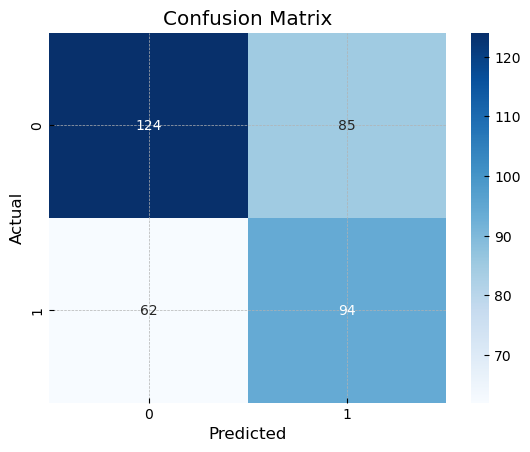

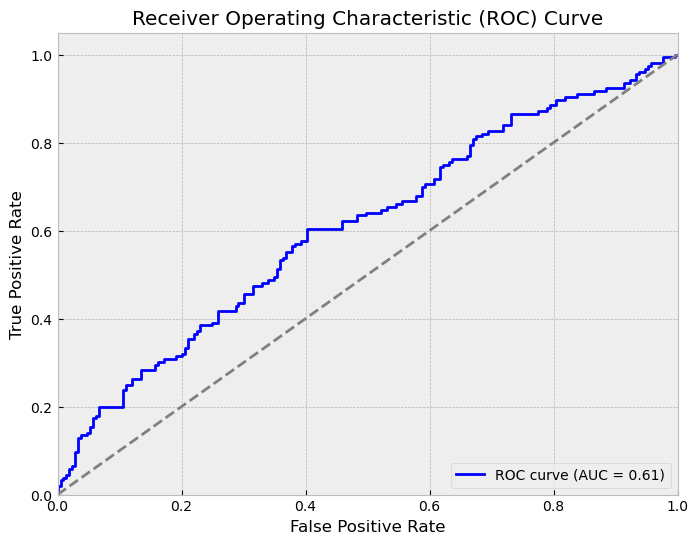

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       209
           1       0.53      0.60      0.56       156

    accuracy                           0.60       365
   macro avg       0.60      0.60      0.59       365
weighted avg       0.61      0.60      0.60       365



In [206]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [207]:
# shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

XGBoostError: [17:47:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api_utils.h:125: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (99324 vs. 41652) : 